In [1]:
import gc
from itertools import combinations
import pathlib
from typing import Any, Dict, List
import warnings
import yaml

from catboost import CatBoostRegressor, Pool
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import polars as pl
from scipy.stats import linregress
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import TimeSeriesSplit

gc.enable()
pd.set_option('display.max_columns', 200)
warnings.simplefilter('ignore')

In [2]:
def preprocess(df: pd.DataFrame) -> pd.DataFrame:
    df = pl.from_pandas(df)

    new_features1 = [
        (pl.col('ask_price') - pl.col('bid_price')).alias('feature1'),
        (pl.col('ask_price') - pl.col('reference_price')).alias('feature2'),
        (pl.col('bid_price') - pl.col('reference_price')).alias('feature3'),
        (pl.col('ask_price') - pl.col('wap')).alias('feature4'),
        (pl.col('bid_price') - pl.col('wap')).alias('feature5'),
        (pl.col('far_price') - pl.col('near_price')).alias('feature6'),
        (pl.col('far_price') - pl.col('reference_price')).alias('feature7'),
        (pl.col('near_price') - pl.col('reference_price')).alias('feature8'),
        (pl.col('ask_size') - pl.col('bid_size')).alias('feature9'),
        (pl.col('ask_size') - pl.col('matched_size')).alias('feature10'),
        (pl.col('bid_size') - pl.col('matched_size')).alias('feature11'),
        (pl.col('imbalance_size') - pl.col('matched_size')).alias('feature12'),
        (pl.col('ask_price') + pl.col('bid_price')).alias('feature13'),
        (pl.col('far_price') + pl.col('near_price')).alias('feature14'),
        (pl.col('ask_size') + pl.col('bid_size')).alias('feature15'),

        ((pl.col('ask_price') - pl.col('bid_price')) / (pl.col('reference_price') - pl.col('bid_price'))).alias('feature16'), 
        ((pl.col('ask_price') - pl.col('bid_price')) / (pl.col('wap') - pl.col('bid_price'))).alias('feature17'), 
        ((pl.col('ask_price') - pl.col('reference_price')) / (pl.col('bid_price') - pl.col('reference_price'))).alias('feature18'), 
        ((pl.col('ask_price') - pl.col('reference_price')) / (pl.col('wap') - pl.col('reference_price'))).alias('feature19'), 
        ((pl.col('ask_price') - pl.col('wap')) / (pl.col('bid_price') - pl.col('wap'))).alias('feature20'), 
        ((pl.col('ask_price') - pl.col('wap')) / (pl.col('reference_price') - pl.col('wap'))).alias('feature21'),
        ((pl.col('bid_price') - pl.col('ask_price')) / (pl.col('reference_price') - pl.col('ask_price'))).alias('feature22'),
        ((pl.col('bid_price') - pl.col('ask_price')) / (pl.col('wap') - pl.col('ask_price'))).alias('feature23'),
        ((pl.col('bid_price') - pl.col('reference_price')) / (pl.col('wap') - pl.col('reference_price'))).alias('feature24'),
        ((pl.col('bid_price') - pl.col('wap')) / (pl.col('reference_price') - pl.col('wap'))).alias('feature25'),
        ((pl.col('reference_price') - pl.col('ask_price')) / (pl.col('wap') - pl.col('ask_price'))).alias('feature26'),
        ((pl.col('reference_price') - pl.col('bid_price')) / (pl.col('wap') - pl.col('bid_price'))).alias('feature27'),

        ((pl.col('ask_size') - pl.col('bid_size')) / (pl.col('matched_size') - pl.col('bid_size'))).alias('feature28'), 
        ((pl.col('ask_size') - pl.col('matched_size')) / (pl.col('bid_size') - pl.col('matched_size'))).alias('feature29'), 
        ((pl.col('bid_size') - pl.col('ask_size')) / (pl.col('matched_size') - pl.col('ask_size'))).alias('feature30'),

        (pl.col('bid_price') / pl.col('ask_price')).alias('feature31'),
        (pl.col('reference_price') / pl.col('ask_price')).alias('feature32'),
        (pl.col('wap') / pl.col('ask_price')).alias('feature33'),
        (pl.col('reference_price') / pl.col('bid_price')).alias('feature34'),
        (pl.col('wap') / pl.col('bid_price')).alias('feature35'),

        (pl.col('bid_size') / pl.col('ask_size')).alias('feature36'),
        (pl.col('ask_size') / pl.col('matched_size')).alias('feature37'),
        (pl.col('bid_size') / pl.col('matched_size')).alias('feature38'),
        ((pl.col('ask_price') - pl.col('bid_price')) * ((pl.col('ask_size') - pl.col('bid_size')) / (pl.col('ask_size') + pl.col('bid_size')))).alias('feature39'),
    ]

    df = (
        df
        .with_columns(new_features1)
        .to_pandas()
    )
    return df

In [3]:
inputs_dir_path = pathlib.Path('../inputs')
outputs_dir_path = pathlib.Path('../outputs')
if not outputs_dir_path.is_dir():
    outputs_dir_path.mkdir()

train_df = pd.read_csv(inputs_dir_path. joinpath('train.csv'))
train_df.drop(columns=['row_id', 'time_id'], inplace=True)
train_df = train_df.astype(np.float32)
display(train_df)
display(train_df.describe())

,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target
0,0.0,0.0,0.0,3.180603e+06,1.0,0.999812,13380277.00,NaN,NaN,0.999812,60651.500000,1.000026,8493.030273,1.000000,-3.029704
1,1.0,0.0,0.0,1.666039e+05,-1.0,0.999896,1642214.25,NaN,NaN,0.999896,3233.040039,1.000660,20605.089844,1.000000,-5.519986
2,2.0,0.0,0.0,3.028799e+05,-1.0,0.999561,1819368.00,NaN,NaN,0.999403,37956.000000,1.000298,18995.000000,1.000000,-8.389950
3,3.0,0.0,0.0,1.191768e+07,-1.0,1.000171,18389746.00,NaN,NaN,0.999999,2324.899902,1.000214,479032.406250,1.000000,-4.010201
4,4.0,0.0,0.0,4.475500e+05,-1.0,0.999532,17860614.00,NaN,NaN,0.999394,16485.539062,1.000016,434.100006,1.000000,-7.349849
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5237975,195.0,480.0,540.0,2.440723e+06,-1.0,1.000317,28280362.00,0.999734,0.999734,1.000317,32257.039062,1.000434,319862.406250,1.000328,2.310276
5237976,196.0,480.0,540.0,3.495105e+05,-1.0,1.000643,9187699.00,1.000129,1.000386,1.000643,205108.406250,1.000900,93393.070312,1.000819,-8.220077
5237977,197.0,480.0,540.0,0.000000e+00,0.0,0.995789,12725436.00,0.995789,0.995789,0.995789,16790.660156,0.995883,180038.312500,0.995797,1.169443
5237978,198.0,480.0,540.0,1.000899e+06,1.0,0.999210,94773272.00,0.999210,0.999210,0.998970,125631.718750,0.999210,669893.000000,0.999008,-1.540184


,stock_id,date_id,seconds_in_bucket,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,target
count,5.237980e+06,5.237980e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237760e+06,2.343638e+06,2.380800e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237980e+06,5.237760e+06,5.237892e+06
mean,9.928867e+01,2.415100e+02,2.699999e+02,5.715294e+06,-1.189619e-02,9.999961e-01,4.510024e+07,1.001713e+00,9.996603e-01,9.997261e-01,5.181356e+04,1.000264e+00,5.357570e+04,9.999929e-01,-4.756123e-02
std,5.787176e+01,1.385319e+02,1.587451e+02,2.051591e+07,8.853374e-01,2.532497e-03,1.398413e+08,7.214705e-01,1.216920e-02,2.499345e-03,1.114214e+05,2.510042e-03,1.293554e+05,2.497509e-03,9.452860e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000e+00,9.352850e-01,4.316610e+03,7.700000e-05,7.869880e-01,9.349150e-01,0.000000e+00,9.398270e-01,0.000000e+00,9.380080e-01,-3.852898e+02
25%,4.900000e+01,1.220000e+02,1.300000e+02,8.453415e+04,-1.000000e+00,9.987630e-01,5.279576e+06,9.963320e-01,9.971000e-01,9.985290e-01,7.374720e+03,9.990290e-01,7.823700e+03,9.987810e-01,-4.559755e+00
50%,9.900000e+01,2.420000e+02,2.700000e+02,1.113604e+06,0.000000e+00,9.999670e-01,1.288264e+07,9.998830e-01,9.998890e-01,9.997280e-01,2.196900e+04,1.000207e+00,2.301792e+04,9.999970e-01,-6.020069e-02
75%,1.490000e+02,3.610000e+02,4.100000e+02,4.190951e+06,1.000000e+00,1.001174e+00,3.270013e+07,1.003318e+00,1.002590e+00,1.000905e+00,5.583168e+04,1.001414e+00,5.787841e+04,1.001149e+00,4.409552e+00
max,1.990000e+02,4.800000e+02,5.400000e+02,2.982028e+09,1.000000e+00,1.077488e+00,7.713682e+09,4.379531e+02,1.309732e+00,1.077488e+00,3.028784e+07,1.077836e+00,5.440500e+07,1.077675e+00,4.460704e+02


In [4]:
def q50(x):
    return x.quantile(0.50)

def iqr(x):
    return x.quantile(0.75) - x.quantile(0.25)

,target_reference_price_mean,target_reference_price_std,target_far_price_mean,target_far_price_std,target_near_price_mean,target_near_price_std,target_bid_price_mean,target_bid_price_std,target_ask_price_mean,target_ask_price_std,target_wap_mean,target_wap_std
count,95232.000000,95232.000000,95212.000000,95210.000000,95232.000000,95232.000000,95232.000000,95232.000000,95232.000000,95232.000000,95232.000000,95232.000000
mean,0.999996,0.001164,1.002956,0.014600,0.999660,0.003727,0.999726,0.001145,1.000265,0.001147,0.999992,0.001155
std,0.002118,0.000781,0.425573,0.865223,0.010284,0.005496,0.002093,0.000768,0.002105,0.000766,0.002087,0.000764
min,0.973249,0.000000,0.715920,0.000000,0.910535,0.000000,0.971857,0.000000,0.974224,0.000000,0.973152,0.000037
25%,0.998833,0.000656,0.994292,0.000684,0.996434,0.000577,0.998601,0.000645,0.999091,0.000648,0.998846,0.000657
50%,0.999954,0.000968,0.999845,0.003017,0.999859,0.001439,0.999727,0.000951,1.000181,0.000956,0.999951,0.000963
75%,1.001102,0.001449,1.005149,0.008979,1.003097,0.004686,1.000843,0.001426,1.001338,0.001429,1.001084,0.001435
max,1.044313,0.021726,103.692535,158.887177,1.155919,0.094262,1.038383,0.021644,1.044632,0.021289,1.040546,0.021464


12


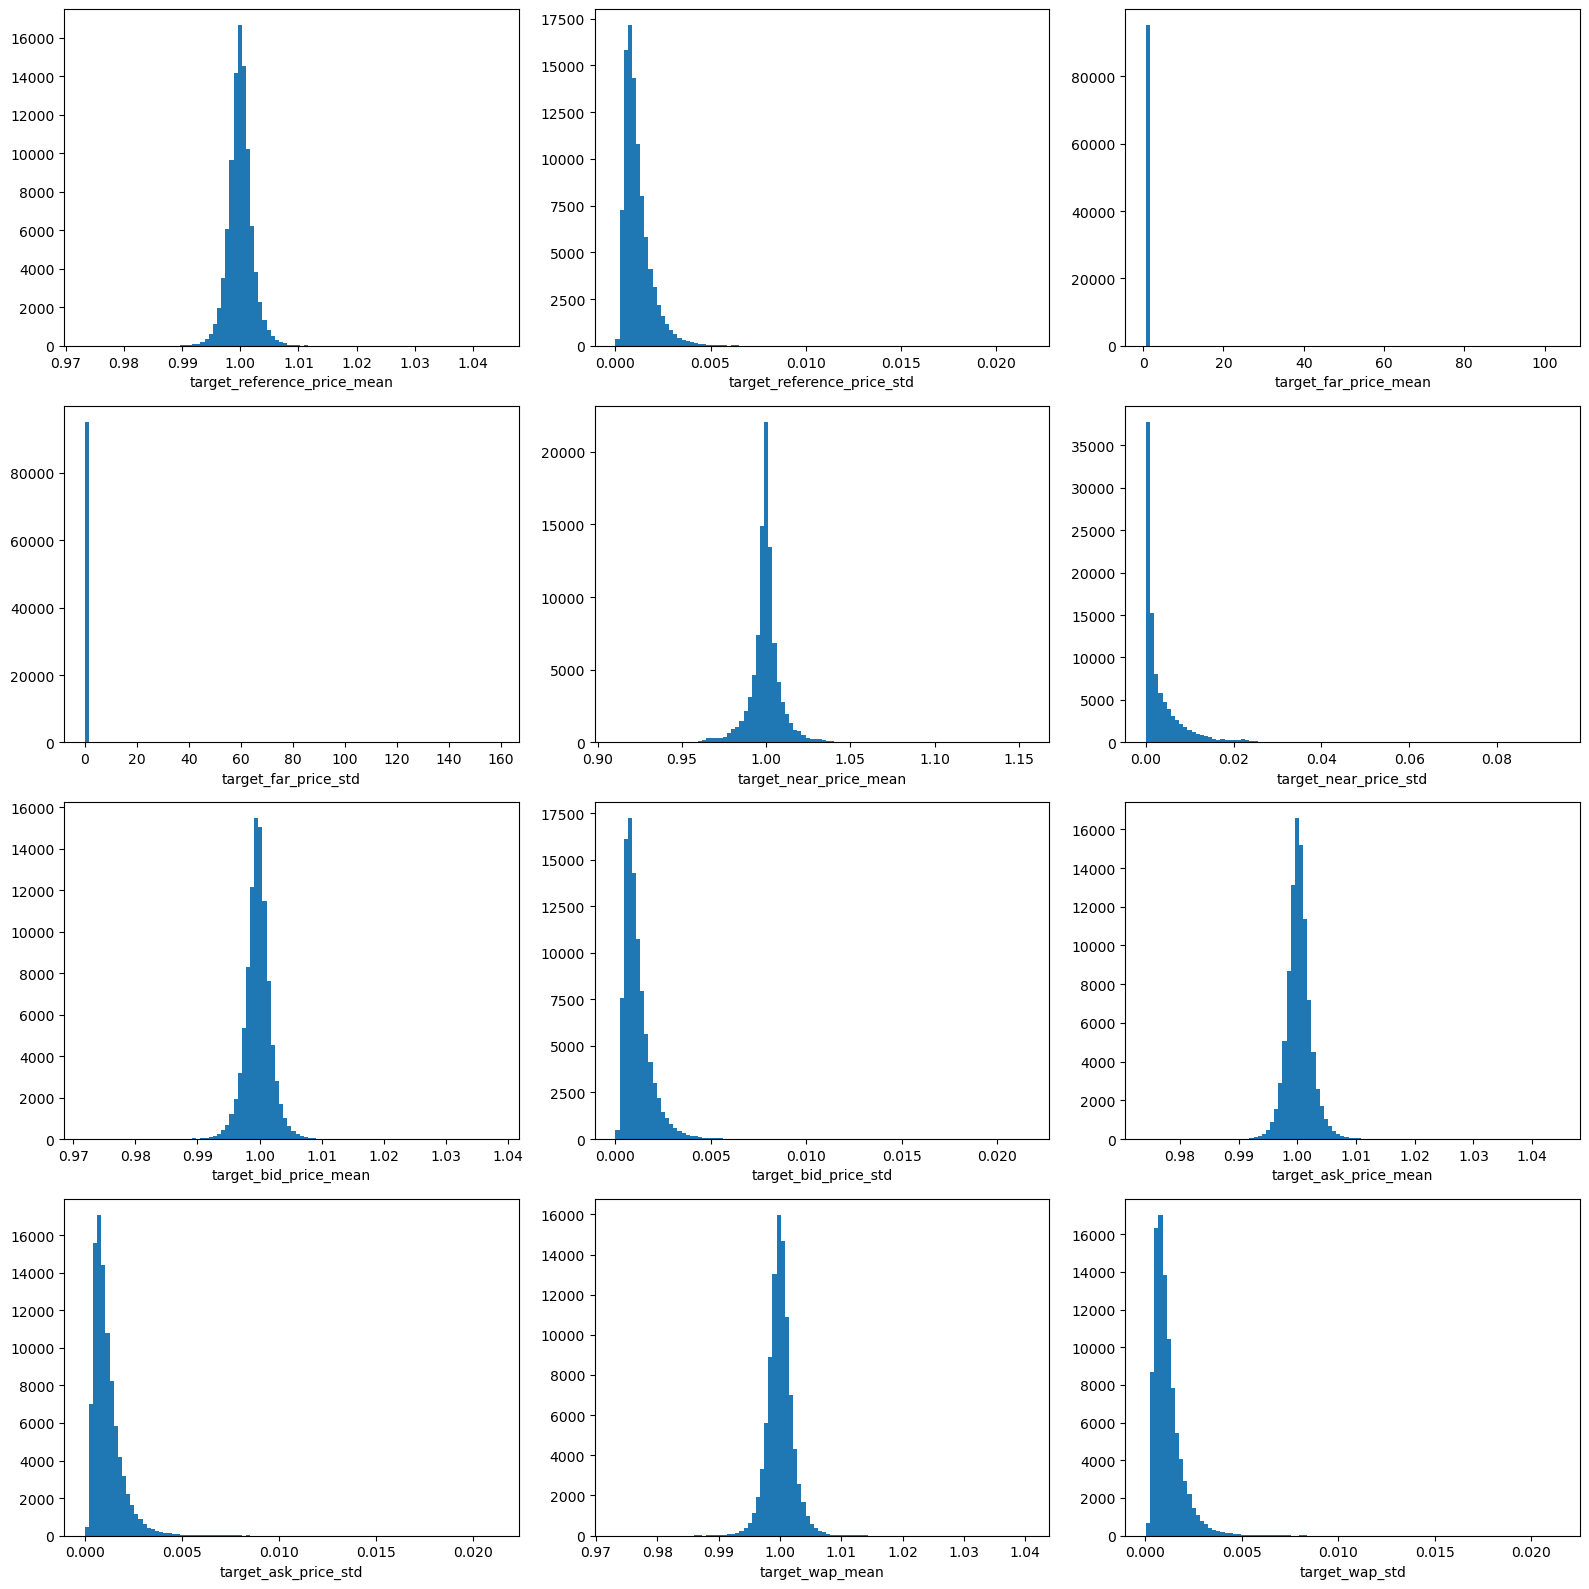

target_reference_price_mean  target_reference_price_std  \
stock_id date_id                                                            
0.0      0.0                         0.999664                    0.000435   
         1.0                         0.999050                    0.000391   
         2.0                         0.998940                    0.000498   
         3.0                         0.998883                    0.000741   
         4.0                         1.000689                    0.000901   

                  target_far_price_mean  target_far_price_std  \
stock_id date_id                                                
0.0      0.0                   0.999692              0.000521   
         1.0                   1.009668              0.006552   
         2.0                   0.998583              0.000233   
         3.0                   0.977043              0.027838   
         4.0                   0.985712              0.007217   

                  target_near_price_mean  target_near_price_std  \
stock_id date_id                                                  
0.0      0.0                    0.999615               0.000448   
         1.0                    1.003035               0.002445   
         2.0                    0.998583               0.000233   
         3.0                    0.938763               0.038452   
         4.0                    0.986791               0.007209   

                  target_bid_price_mean  target_bid_price_std  \
stock_id date_id                                                
0.0      0.0                   0.999547              0.000430   
         1.0                   0.998903              0.000387   
         2.0                   0.998895              0.000509   
         3.0                   0.998834              0.000763   
         4.0                   1.000637              0.000900   

                  target_ask_price_mean  target_ask_price_std  \
stock_id date_id                                                
0.0      0.0                   0.999697              0.000457   
         1.0                   0.999091              0.000467   
         2.0                   0.999039              0.000511   
         3.0                   0.999015              0.000753   
         4.0                   1.000925              0.000965   

                  target_wap_mean  target_wap_std  
stock_id date_id                                   
0.0      0.0             0.999618        0.000440  
         1.0             0.999000        0.000416  
         2.0             0.998962        0.000509  
         3.0             0.998919        0.000764  
         4.0             1.000755        0.000933

target_reference_price_mean  target_reference_price_std  \
stock_id date_id                                                            
0.0      0.0                         0.692979                    6.078273   
         1.0                         0.692672                    5.970583   
         2.0                         0.692617                    6.211764   
         3.0                         0.692589                    6.609187   
         4.0                         0.693492                    6.804755   

                  target_far_price_mean  target_far_price_std  \
stock_id date_id                                                
0.0      0.0                   0.692993              6.257366   
         1.0                   0.697969              8.787727   
         2.0                   0.692439              5.454497   
         3.0                   0.681602             10.234209   
         4.0                   0.685977              8.884350   

                  target_near_price_mean  target_near_price_std  \
stock_id date_id                                                  
0.0      0.0                    0.692955               6.106844   
         1.0                    0.694664               7.802283   
         2.0                    0.692439               5.454497   
         3.0                    0.662050              10.557204   
         4.0                    0.686521               8.883268   

                  target_bid_price_mean  target_bid_price_std  \
stock_id date_id                                                
0.0      0.0                   0.692921              6.065131   
         1.0                   0.692599              5.962000   
         2.0                   0.692594              6.234771   
         3.0                   0.692564              6.639210   
         4.0                   0.693466              6.803568   

                  target_ask_price_mean  target_ask_price_std  \
stock_id date_id                                                
0.0      0.0                   0.692996              6.126606   
         1.0                   0.692693              6.148734   
         2.0                   0.692666              6.238996   
         3.0                   0.692655              6.625522   
         4.0                   0.693610              6.873087   

                  target_wap_mean  target_wap_std  
stock_id date_id                                   
0.0      0.0             0.692956        6.089807  
         1.0             0.692647        6.032526  
         2.0             0.692628        6.233563  
         3.0             0.692607        6.640256  
         4.0             0.693525        6.839837

12


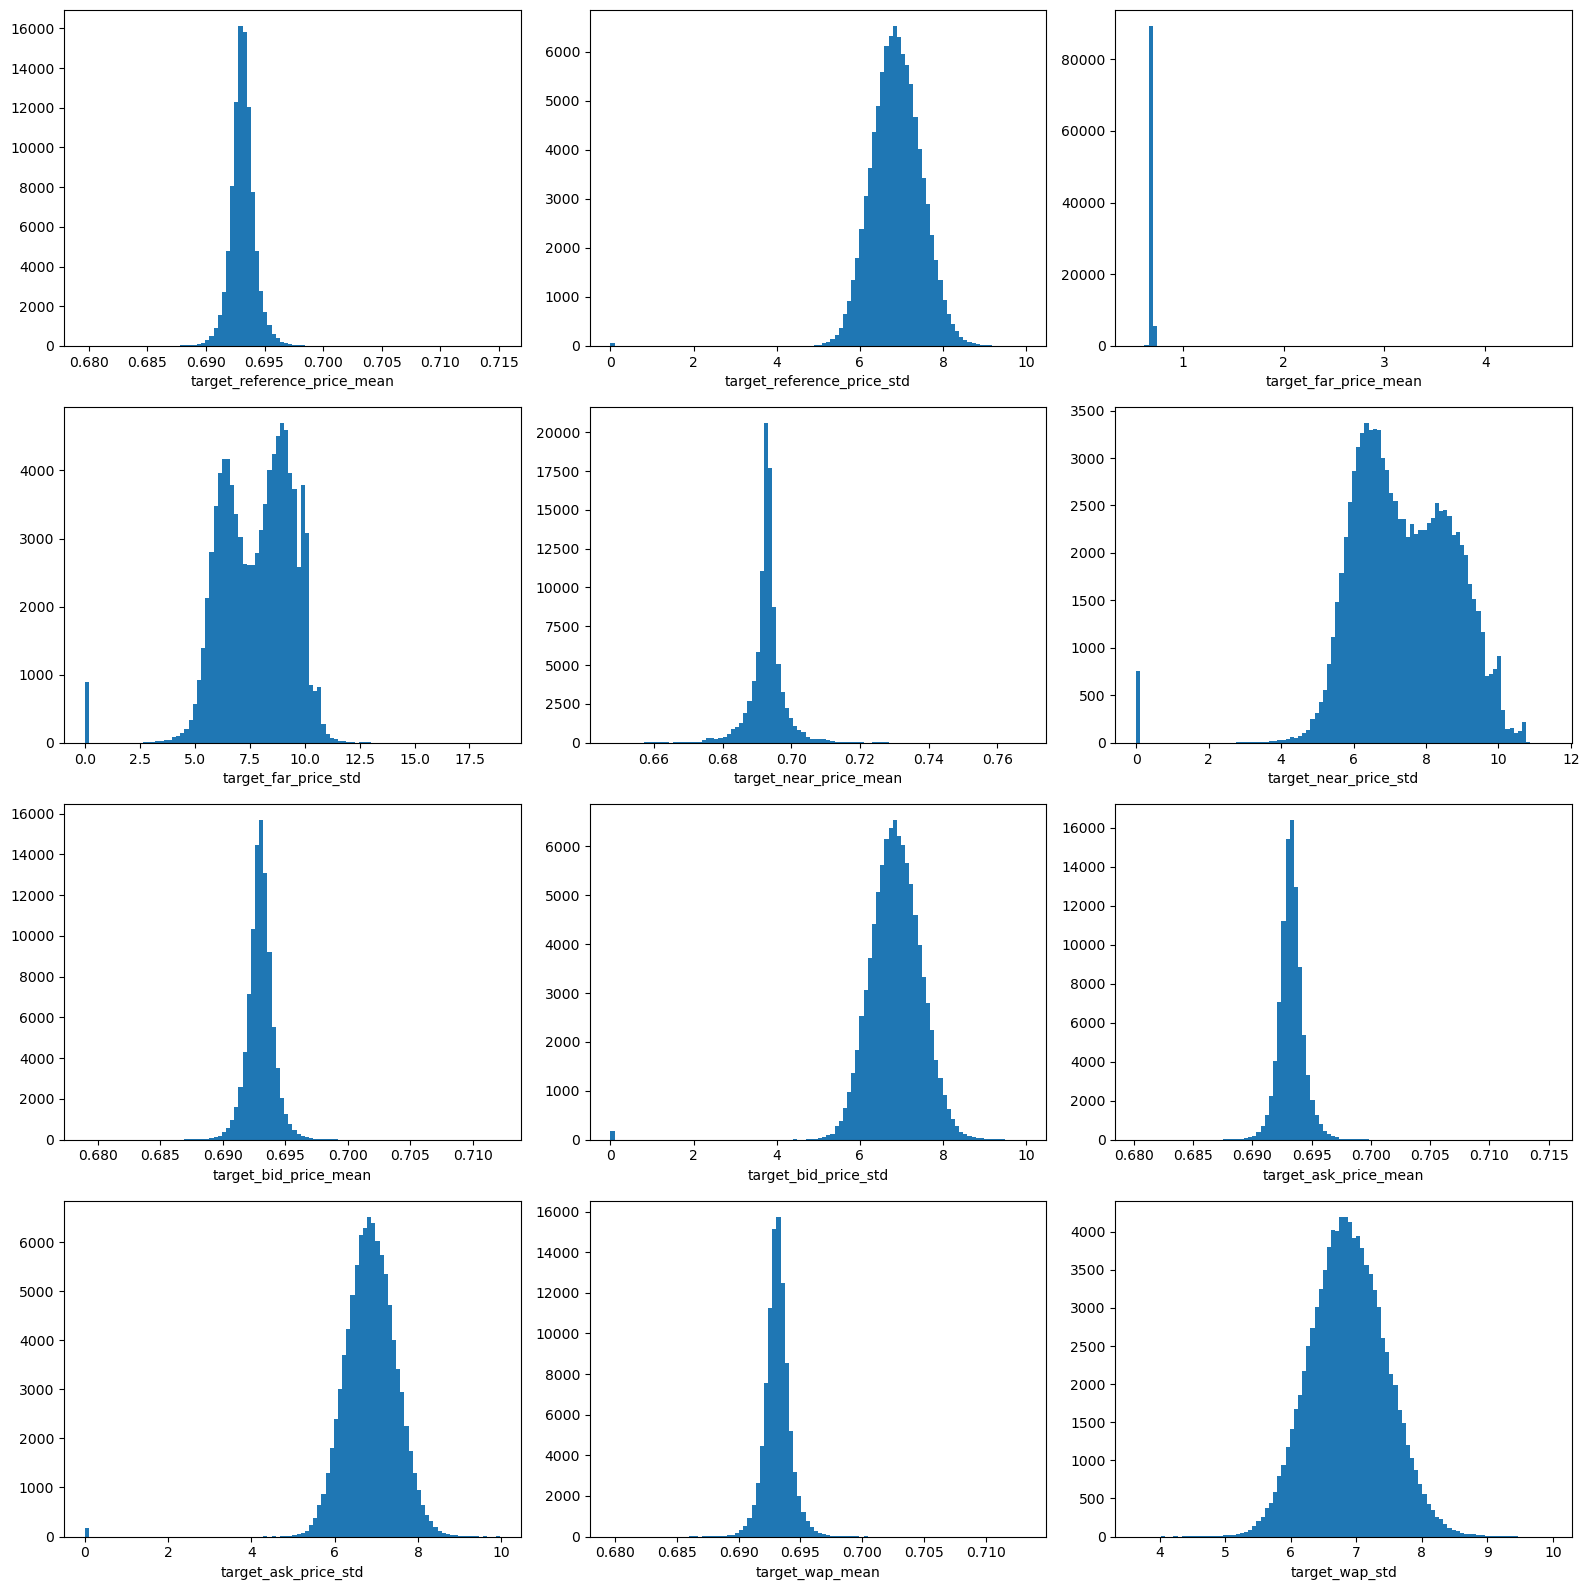

In [5]:
except_features = [
    'seconds_in_bucket',
    'imbalance_buy_sell_flag',
    'date_id',
    'stock_id',
    'target',
    'imbalance_size',
    'matched_size',
    'ask_size',
    'bid_size',
]

agg_features = [col for col in train_df.columns if col not in except_features]
statistics_per_date = train_df.groupby(['stock_id', 'date_id'])[agg_features].agg(['mean', 'std'])
statistics_per_date.columns = ['target_'+'_'.join(col) for col in statistics_per_date.columns]
display(statistics_per_date.describe())

target_columns = [col for col in statistics_per_date.columns if 'target' in col]
num_targets = len(target_columns)
print(num_targets)
nrows = num_targets // 3 if num_targets % 3 == 0 else num_targets // 3 + 1

_, axs = plt.subplots(nrows, 3, figsize=(16, 16))
for i in range(num_targets):
    axs[i//3, i%3].hist(statistics_per_date[target_columns[i]], bins=100)
    axs[i//3, i%3].set_xlabel(target_columns[i])
plt.tight_layout()
plt.show()

display(statistics_per_date.head())
for col in statistics_per_date.columns:
    if 'mean' in col:
        statistics_per_date[col] = np.log1p(statistics_per_date[col])
    elif 'std' in col:
        statistics_per_date[col] = np.log1p(1e+06 * statistics_per_date[col])
    elif 'iqr' in col:
        statistics_per_date[col] = np.log1p(statistics_per_date[col])
display(statistics_per_date.head())

target_columns = [col for col in statistics_per_date.columns if 'target' in col]
num_targets = len(target_columns)
print(num_targets)
nrows = num_targets // 3 if num_targets % 3 == 0 else num_targets // 3 + 1

_, axs = plt.subplots(nrows, 3, figsize=(16, 16))
for i in range(num_targets):
    axs[i//3, i%3].hist(statistics_per_date[target_columns[i]], bins=100)
    axs[i//3, i%3].set_xlabel(target_columns[i])
plt.tight_layout()
plt.show()

In [6]:
train_df = preprocess(train_df)
train_df = train_df.groupby(['stock_id', 'date_id']).first().drop(columns=['target', 'seconds_in_bucket'])

train_df = train_df.merge(statistics_per_date, on=['stock_id', 'date_id']).reset_index()
train_df.dropna(inplace=True)
display(train_df)

del statistics_per_date
gc.collect()

,stock_id,date_id,imbalance_size,imbalance_buy_sell_flag,reference_price,matched_size,far_price,near_price,bid_price,bid_size,ask_price,ask_size,wap,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,feature11,feature12,feature13,feature14,feature15,feature16,feature17,feature18,feature19,feature20,feature21,feature22,feature23,feature24,feature25,feature26,feature27,feature28,feature29,feature30,feature31,feature32,feature33,feature34,feature35,feature36,feature37,feature38,feature39,target_reference_price_mean,target_reference_price_std,target_far_price_mean,target_far_price_std,target_near_price_mean,target_near_price_std,target_bid_price_mean,target_bid_price_std,target_ask_price_mean,target_ask_price_std,target_wap_mean,target_wap_std
0,0.0,0.0,3180602.750,1.0,0.999812,13380277.0,1.000241,1.000241,0.999812,60651.500000,1.000026,8493.030273,1.0,0.000214,0.000214,0.000000,0.000026,-0.000188,0.000000,0.000000,0.000000,-52158.468750,-13371784.0,-13319626.0,-10199674.00,1.999838,2.000482,69144.531250,inf,1.138237,inf,1.138237,-0.138237,-0.138237,1.000000,8.233945,0.000000,1.000000,8.233945,0.000000,-0.003916,1.003916,0.003901,0.999786,0.999786,0.999974,1.000000,1.000188,7.141326,0.000635,0.004533,-0.000161,0.692979,6.078273,0.692993,6.257366,0.692955,6.106844,0.692921,6.065131,0.692996,6.126606,0.692956,6.089807
1,0.0,1.0,1870169.375,1.0,0.999923,5132566.5,1.018514,1.010132,0.999601,9302.000000,1.000998,23287.500000,1.0,0.001397,0.001075,-0.000322,0.000998,-0.000399,0.008382,0.018913,0.010531,13985.500000,-5109279.0,-5123264.5,-3262397.00,2.000599,2.028646,32589.500000,4.338763,3.501344,-3.338763,13.959752,-2.501344,-12.959752,1.299512,1.399785,-4.181115,5.181115,1.077162,0.806991,0.002730,0.997270,-0.002737,0.998604,0.998926,0.999003,1.000322,1.000399,0.399442,0.004537,0.001812,0.000600,0.692672,5.970583,0.697969,8.787727,0.694664,7.802283,0.692599,5.962000,0.692693,6.148734,0.692647,6.032526
2,0.0,2.0,0.000,0.0,0.999968,9704431.0,0.998774,0.998774,0.999968,4055.479980,1.000185,23231.880859,1.0,0.000217,0.000217,0.000000,0.000185,-0.000032,0.000000,0.000000,0.000000,19176.400391,-9681199.0,-9700376.0,-9704431.00,2.000153,1.997548,27287.361328,inf,6.780261,inf,6.780261,-5.780261,-5.780261,1.000000,1.173003,0.000000,1.000000,1.173003,0.000000,0.001977,0.998023,-0.001981,0.999783,0.999783,0.999815,1.000000,1.000032,0.174565,0.002394,0.000418,0.000153,0.692617,6.211764,0.692439,5.454497,0.692439,5.454497,0.692594,6.234771,0.692666,6.238996,0.692628,6.233563
3,0.0,3.0,3993793.750,-1.0,1.000232,8122459.5,0.908138,0.908138,0.999907,9218.000000,1.000341,33752.519531,1.0,0.000434,0.000109,-0.000325,0.000341,-0.000093,-0.050983,-0.089708,-0.090684,24534.519531,-8088707.0,-8113241.5,-4128665.75,2.000248,1.867259,42970.519531,1.335657,4.667949,-0.335657,-0.470195,-3.667949,1.470195,3.979235,1.272632,1.400822,-0.400822,0.319818,3.494872,0.003024,0.996976,-0.003033,0.999566,0.999891,0.999659,1.000325,1.000093,0.273106,0.004155,0.001135,0.000248,0.692589,6.609187,0.681602,10.234209,0.662050,10.557204,0.692564,6.639210,0.692655,6.625522,0.692607,6.640256
4,0.0,4.0,4529594.000,-1.0,1.000232,10151651.0,0.980448,0.980551,0.999923,46870.320312,1.000335,204062.156250,1.0,0.000412,0.000103,-0.000309,0.000335,-0.000077,-0.000103,-0.019887,-0.019784,157191.843750,-9947589.0,-10104781.0,-5622057.00,2.000258,1.960999,250932.468750,1.333333,5.349845,-0.333333,-0.443988,-4.349845,1.443988,4.000000,1.229893,1.331963,-0.331963,0.307473,4.012384,0.015556,0.984444,-0.015802,0.999588,0.999897,0.999665,1.000309,1.000077,0.229686,0.020101,0.004617,0.000258,0.693492,6.804755,0.685977,8.884350,0.686521,8.883268,0.693466,6.803568,0.693610,6.873087,0.693525,6.839837
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
952

0

## train catboost models using cross validation

In [7]:
def train(
        dataset: pd.DataFrame,
        model_params: Dict[str, Any],
        outputs_dir: pathlib.Path,
    ):
    
    target_columns = [col for col in dataset.columns if 'target' in col]
    print(target_columns)
    feature_columns = [col for col in dataset.columns if col not in target_columns and col != 'date_id']
    days= np.arange(dataset['date_id'].min(), dataset['date_id'].max())
    fimps = []
    result_pred = np.zeros((11990, 12))
    result_true = np.zeros((11990, 12))

    history = {
        'train_mae': [],
        'valid_mae': [],
    }

    mean_num_iteration = 0

    step = 60
    valid_days = days[-step:]
    valid_X = dataset.query('date_id in @valid_days')[feature_columns]
    valid_y = dataset.query('date_id in @valid_days')[target_columns]

    train_day_lower_limits = np.arange(0, 480-step, step)

    for k, lower_limit in enumerate(train_day_lower_limits):
        train_days = np.arange(lower_limit, lower_limit+step)
        print(f'fold {k+1}')
        print(train_days)
        print(valid_days)
        
        plot_time(days, train_days, valid_days)
        
        train_X = dataset.query('date_id in @train_days')[feature_columns]
        train_y = dataset.query('date_id in @train_days')[target_columns]
        print(f'train_X.shape: {train_X.shape}, train_y.shape: {train_y.shape}')
        print(f'valid_X.shape: {valid_X.shape}, valid_y.shape: {valid_y.shape}')
        
        train_pool = Pool(data=train_X, label=train_y)
        valid_pool = Pool(data=valid_X, label=valid_y)
        
        model = CatBoostRegressor(**model_params)
        model.fit(
            X=train_pool,
            eval_set=[(valid_pool)],
            use_best_model=True,
            early_stopping_rounds=100,
            verbose=500,
        )
        model.save_model(
            outputs_dir.joinpath(f'catboost_fold{k+1}_predict_price_statistics.txt'),
        )
        
        fimp = model.get_feature_importance(valid_pool, type='PredictionValuesChange')
        fimp = pd.DataFrame(fimp, index=feature_columns, columns=[f'fold{k+1}'])
        fimps.append(fimp)

        train_pred = model.predict(train_X)
        valid_pred = model.predict(valid_X)
        
        result_pred += valid_pred
        result_true += valid_y.values

        history['train_mae'].append(np.mean(abs(train_y.values - train_pred), axis=0))
        history['valid_mae'].append(np.mean(abs(valid_y.values - valid_pred), axis=0))

        mean_num_iteration += model.get_best_iteration()

        del train_X, train_y, train_pool, valid_pool, model, fimp
        del train_pred, valid_pred
        gc.collect()

    del valid_X, valid_y
    gc.collect()

    history = pd.DataFrame.from_dict(history)
    mean_num_iteration = int(mean_num_iteration / len(train_day_lower_limits))

    result_pred /= len(train_day_lower_limits)
    result_true /= len(train_day_lower_limits)
    
    fimps = pd.concat(fimps, axis=1)
    mean_fimps = fimps.mean(axis=1)
    std_fimps = fimps.std(axis=1)
    fimps['mean_fimps'] = mean_fimps
    fimps['std_fimps'] = std_fimps
    fimps.sort_values(by='mean_fimps', inplace=True)
    fimps.index = [f'{len(fimps)-i}_{idx}' for i, idx in enumerate(fimps.index)]
    
    return history, result_pred, result_true, fimps, mean_num_iteration


def plot_time(all_time, train_time, valid_time):
    _, ax = plt.subplots()
    ax.barh(y='all', height=0.6, width=len(all_time), left=0, color='tab:blue')
    ax.barh(y='train+valid+test', height=0.6, width=[len(train_time), len(valid_time)],
            left=[train_time.min(), valid_time.min()], color=['tab:orange', 'tab:green', 'tab:red'])
    xcenter = [len(all_time)//2, train_time.min()+len(train_time)//2,
               valid_time.min()+len(valid_time)//2]
    ycenter = [0, 1, 1, 1]
    width = [f'all\n{len(all_time)}', f'train\n{len(train_time)}', f'valid\n{len(valid_time)}']
    for x, y, w in zip(xcenter, ycenter, width):
        ax.text(x, y, str(w),  ha='center', va='center')
    ax.set_xticks([train_time.min(), train_time.max(), valid_time.min(), len(all_time)])
    ax.grid(axis='x', linestyle='--')
    ax.tick_params(axis='x', labelrotation=45)
    plt.show()

['target_reference_price_mean', 'target_reference_price_std', 'target_far_price_mean', 'target_far_price_std', 'target_near_price_mean', 'target_near_price_std', 'target_bid_price_mean', 'target_bid_price_std', 'target_ask_price_mean', 'target_ask_price_std', 'target_wap_mean', 'target_wap_std']
fold 1
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59]
[420. 421. 422. 423. 424. 425. 426. 427. 428. 429. 430. 431. 432. 433.
 434. 435. 436. 437. 438. 439. 440. 441. 442. 443. 444. 445. 446. 447.
 448. 449. 450. 451. 452. 453. 454. 455. 456. 457. 458. 459. 460. 461.
 462. 463. 464. 465. 466. 467. 468. 469. 470. 471. 472. 473. 474. 475.
 476. 477. 478. 479.]


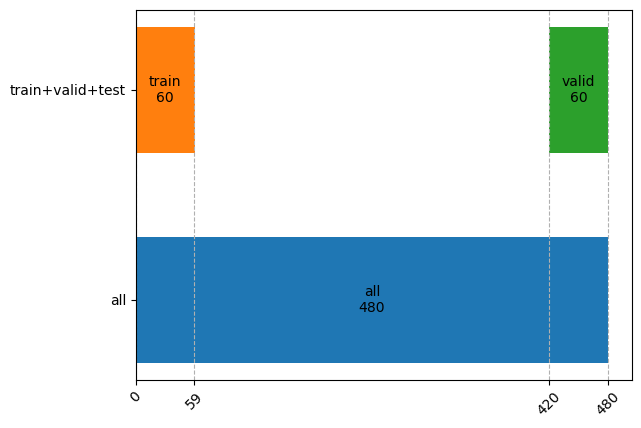

train_X.shape: (11561, 51), train_y.shape: (11561, 12)
valid_X.shape: (11990, 51), valid_y.shape: (11990, 12)
0:	learn: 2.3949645	test: 2.9341838	best: 2.9341838 (0)	total: 244ms	remaining: 20m 20s
500:	learn: 1.3510648	test: 1.8109425	best: 1.8109425 (500)	total: 1m 39s	remaining: 14m 57s
1000:	learn: 1.2290446	test: 1.7593075	best: 1.7593075 (1000)	total: 3m 18s	remaining: 13m 14s
1500:	learn: 1.1393538	test: 1.7467213	best: 1.7467213 (1500)	total: 4m 57s	remaining: 11m 34s
2000:	learn: 1.0602386	test: 1.7394038	best: 1.7394020 (1998)	total: 6m 36s	remaining: 9m 54s
2500:	learn: 0.9894529	test: 1.7322811	best: 1.7322811 (2500)	total: 8m 15s	remaining: 8m 15s
3000:	learn: 0.9238876	test: 1.7277477	best: 1.7277477 (3000)	total: 9m 54s	remaining: 6m 36s
3500:	learn: 0.8633282	test: 1.7252220	best: 1.7252220 (3500)	total: 11m 33s	remaining: 4m 56s
4000:	learn: 0.8063526	test: 1.7235590	best: 1.7235453 (3999)	total: 13m 12s	remaining: 3m 17s
4500:	learn: 0.7538395	test: 1.7225353	best: 1.

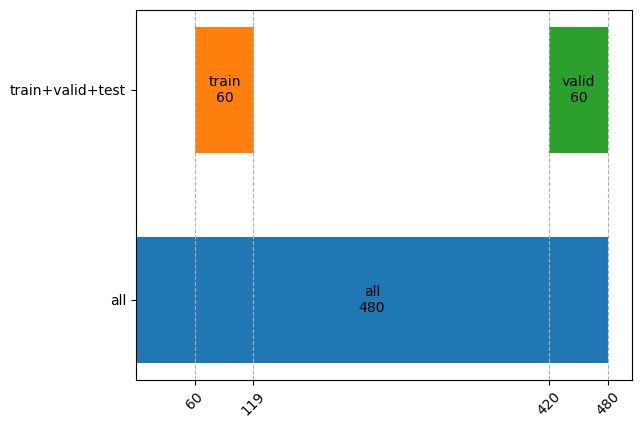

train_X.shape: (11779, 51), train_y.shape: (11779, 12)
valid_X.shape: (11990, 51), valid_y.shape: (11990, 12)
0:	learn: 2.4722415	test: 2.8245086	best: 2.8245086 (0)	total: 187ms	remaining: 15m 36s
500:	learn: 1.4074725	test: 1.8404844	best: 1.8404844 (500)	total: 1m 39s	remaining: 14m 54s
1000:	learn: 1.2811892	test: 1.7922621	best: 1.7922621 (1000)	total: 3m 18s	remaining: 13m 12s
1500:	learn: 1.1898141	test: 1.7779031	best: 1.7778929 (1499)	total: 4m 57s	remaining: 11m 33s
2000:	learn: 1.1127080	test: 1.7689307	best: 1.7689307 (2000)	total: 6m 36s	remaining: 9m 53s
2500:	learn: 1.0406310	test: 1.7596206	best: 1.7596038 (2497)	total: 8m 15s	remaining: 8m 14s
3000:	learn: 0.9743285	test: 1.7537521	best: 1.7537142 (2994)	total: 9m 54s	remaining: 6m 35s
3500:	learn: 0.9124895	test: 1.7501677	best: 1.7501671 (3498)	total: 11m 32s	remaining: 4m 56s
4000:	learn: 0.8536440	test: 1.7477981	best: 1.7477981 (4000)	total: 13m 11s	remaining: 3m 17s
4500:	learn: 0.7999567	test: 1.7461512	best: 1.

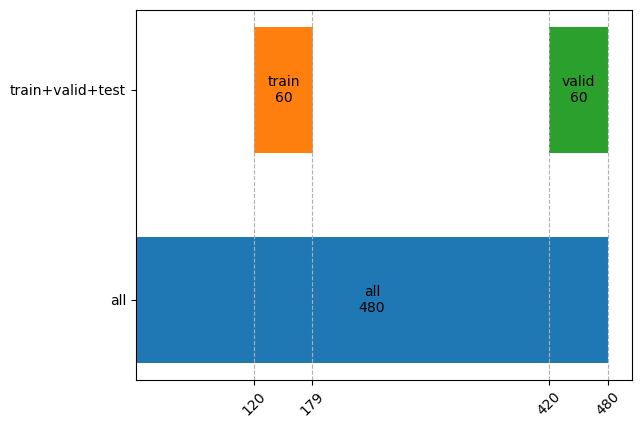

train_X.shape: (11818, 51), train_y.shape: (11818, 12)
valid_X.shape: (11990, 51), valid_y.shape: (11990, 12)
0:	learn: 2.3925897	test: 2.8719200	best: 2.8719200 (0)	total: 186ms	remaining: 15m 30s
500:	learn: 1.3382858	test: 1.9402177	best: 1.9402177 (500)	total: 1m 39s	remaining: 14m 50s
1000:	learn: 1.2168302	test: 1.8762270	best: 1.8762270 (1000)	total: 3m 18s	remaining: 13m 11s
1500:	learn: 1.1294827	test: 1.8553650	best: 1.8553650 (1500)	total: 4m 57s	remaining: 11m 32s
2000:	learn: 1.0514969	test: 1.8441151	best: 1.8441129 (1999)	total: 6m 36s	remaining: 9m 54s
2500:	learn: 0.9821047	test: 1.8329739	best: 1.8329739 (2500)	total: 8m 15s	remaining: 8m 14s
3000:	learn: 0.9165811	test: 1.8253828	best: 1.8253828 (3000)	total: 9m 54s	remaining: 6m 35s
3500:	learn: 0.8576704	test: 1.8207245	best: 1.8207245 (3500)	total: 11m 32s	remaining: 4m 56s
4000:	learn: 0.8011063	test: 1.8172381	best: 1.8172381 (4000)	total: 13m 11s	remaining: 3m 17s
4500:	learn: 0.7474940	test: 1.8151406	best: 1.

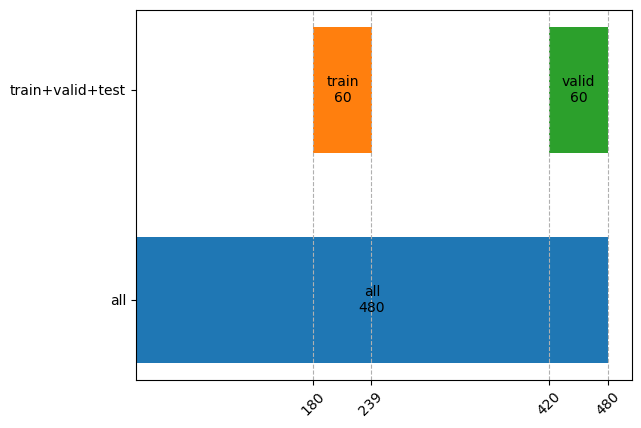

train_X.shape: (11925, 51), train_y.shape: (11925, 12)
valid_X.shape: (11990, 51), valid_y.shape: (11990, 12)
0:	learn: 2.3545033	test: 2.8884710	best: 2.8884710 (0)	total: 187ms	remaining: 15m 33s
500:	learn: 1.3244277	test: 1.9269692	best: 1.9269692 (500)	total: 1m 39s	remaining: 14m 51s
1000:	learn: 1.2020618	test: 1.8547004	best: 1.8547004 (1000)	total: 3m 18s	remaining: 13m 11s
1500:	learn: 1.1163766	test: 1.8323039	best: 1.8323039 (1500)	total: 4m 57s	remaining: 11m 33s
2000:	learn: 1.0400520	test: 1.8196691	best: 1.8196691 (2000)	total: 6m 36s	remaining: 9m 54s
2500:	learn: 0.9715017	test: 1.8096473	best: 1.8096473 (2500)	total: 8m 15s	remaining: 8m 15s
3000:	learn: 0.9053597	test: 1.8022466	best: 1.8022466 (3000)	total: 9m 54s	remaining: 6m 36s
3500:	learn: 0.8465602	test: 1.7977039	best: 1.7977039 (3500)	total: 11m 33s	remaining: 4m 56s
4000:	learn: 0.7912454	test: 1.7944022	best: 1.7943823 (3994)	total: 13m 12s	remaining: 3m 17s
4500:	learn: 0.7399601	test: 1.7921975	best: 1.

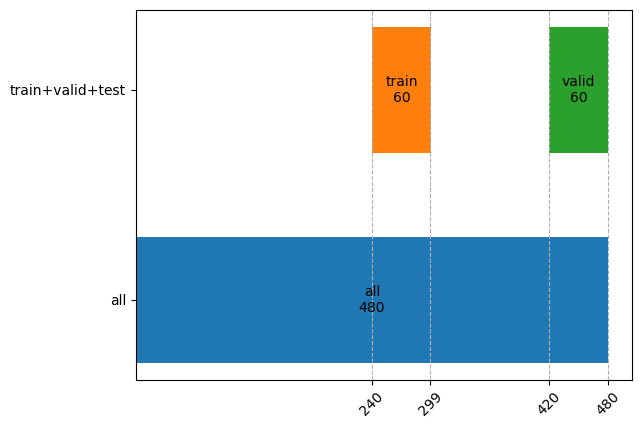

train_X.shape: (11943, 51), train_y.shape: (11943, 12)
valid_X.shape: (11990, 51), valid_y.shape: (11990, 12)
0:	learn: 2.4527608	test: 2.8048769	best: 2.8048769 (0)	total: 187ms	remaining: 15m 34s
500:	learn: 1.3817734	test: 1.8182148	best: 1.8182148 (500)	total: 1m 39s	remaining: 14m 52s
1000:	learn: 1.2430856	test: 1.7524110	best: 1.7524110 (1000)	total: 3m 18s	remaining: 13m 12s
1500:	learn: 1.1493774	test: 1.7329986	best: 1.7329986 (1500)	total: 4m 57s	remaining: 11m 33s
2000:	learn: 1.0709407	test: 1.7217163	best: 1.7217163 (2000)	total: 6m 36s	remaining: 9m 54s
2500:	learn: 0.9996068	test: 1.7111283	best: 1.7111283 (2500)	total: 8m 15s	remaining: 8m 14s
3000:	learn: 0.9339254	test: 1.7032713	best: 1.7032713 (3000)	total: 9m 55s	remaining: 6m 36s
3500:	learn: 0.8736485	test: 1.6982134	best: 1.6982108 (3489)	total: 11m 34s	remaining: 4m 57s
4000:	learn: 0.8164042	test: 1.6946199	best: 1.6946163 (3998)	total: 13m 13s	remaining: 3m 18s
4500:	learn: 0.7641300	test: 1.6926598	best: 1.

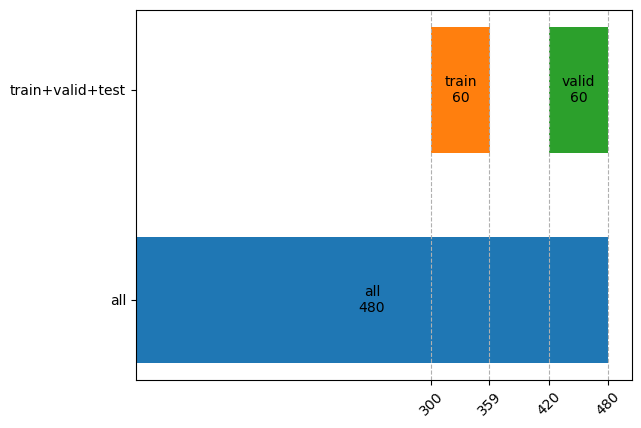

train_X.shape: (11996, 51), train_y.shape: (11996, 12)
valid_X.shape: (11990, 51), valid_y.shape: (11990, 12)
0:	learn: 2.5543136	test: 2.8170296	best: 2.8170296 (0)	total: 187ms	remaining: 15m 34s
500:	learn: 1.4741297	test: 1.8333280	best: 1.8333280 (500)	total: 1m 39s	remaining: 14m 50s
1000:	learn: 1.3248158	test: 1.7704727	best: 1.7704727 (1000)	total: 3m 18s	remaining: 13m 11s
1500:	learn: 1.2234449	test: 1.7508717	best: 1.7508717 (1500)	total: 4m 57s	remaining: 11m 33s
2000:	learn: 1.1412077	test: 1.7407515	best: 1.7407515 (2000)	total: 6m 36s	remaining: 9m 54s
2500:	learn: 1.0662647	test: 1.7308216	best: 1.7308216 (2500)	total: 8m 15s	remaining: 8m 15s
3000:	learn: 0.9960459	test: 1.7245105	best: 1.7245105 (3000)	total: 9m 54s	remaining: 6m 36s
3500:	learn: 0.9327100	test: 1.7194674	best: 1.7194674 (3500)	total: 11m 34s	remaining: 4m 57s
4000:	learn: 0.8740376	test: 1.7164900	best: 1.7164868 (3999)	total: 13m 14s	remaining: 3m 18s
4500:	learn: 0.8199712	test: 1.7143303	best: 1.

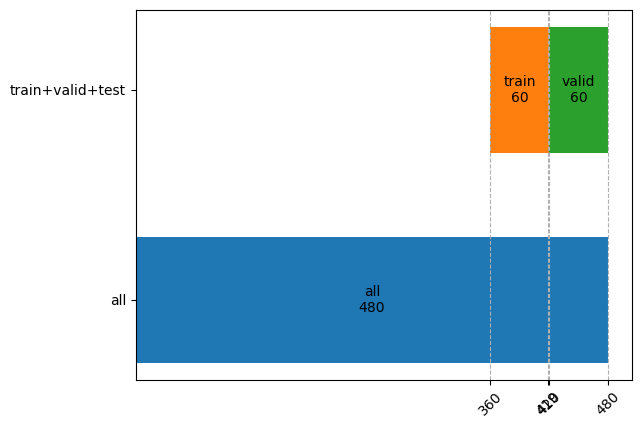

train_X.shape: (11998, 51), train_y.shape: (11998, 12)
valid_X.shape: (11990, 51), valid_y.shape: (11990, 12)
0:	learn: 2.6076169	test: 2.8053668	best: 2.8053668 (0)	total: 185ms	remaining: 15m 23s
500:	learn: 1.5133350	test: 1.8028007	best: 1.8028007 (500)	total: 1m 39s	remaining: 14m 49s
1000:	learn: 1.3597042	test: 1.7364447	best: 1.7364447 (1000)	total: 3m 17s	remaining: 13m 10s
1500:	learn: 1.2556299	test: 1.7152530	best: 1.7152530 (1500)	total: 4m 56s	remaining: 11m 31s
2000:	learn: 1.1686706	test: 1.7034120	best: 1.7034120 (2000)	total: 6m 35s	remaining: 9m 53s
2500:	learn: 1.0923931	test: 1.6930372	best: 1.6930372 (2500)	total: 8m 14s	remaining: 8m 14s
3000:	learn: 1.0203739	test: 1.6854387	best: 1.6854364 (2999)	total: 9m 53s	remaining: 6m 35s
3500:	learn: 0.9542419	test: 1.6801300	best: 1.6801300 (3500)	total: 11m 32s	remaining: 4m 56s
4000:	learn: 0.8951556	test: 1.6765924	best: 1.6765924 (4000)	total: 13m 11s	remaining: 3m 17s
4500:	learn: 0.8392645	test: 1.6741760	best: 1.

In [8]:
params = {
    'loss_function': 'MultiRMSE',
    'eval_metric': 'MultiRMSE',
    'iterations': 5000,
    'depth': 10,
    'learning_rate': 5e-03,
    'random_state': 42,
    'bagging_temperature': 0.8,
    'random_strength': 0.8,
    #'subsample': 0.8,
    'colsample_bylevel': 0.8,
    'l2_leaf_reg': 0.0,
    'min_data_in_leaf': 20,
}

history, result_pred, result_true, fimps, mean_num_iteration = train(
    dataset=train_df,
    model_params=params,
    outputs_dir=outputs_dir_path,
)

array([[0.69286541, 6.60996001, 0.68792269, ..., 6.61417381, 0.69290112,
        6.61820031],
       [0.693562  , 6.82401978, 0.70343448, ..., 6.83037024, 0.69351303,
        6.83672463],
       [0.69297334, 6.51118533, 0.68829157, ..., 6.51140569, 0.69300111,
        6.51563473],
       ...,
       [0.69250431, 6.93412986, 0.67905894, ..., 6.93446674, 0.69253634,
        6.93652429],
       [0.69348214, 6.70460149, 0.69858554, ..., 6.69098345, 0.69344319,
        6.69830286],
       [0.69397542, 7.32407074, 0.7064136 , ..., 7.28750333, 0.69399338,
        7.29577908]])

array([[0.69289547, 6.7458334 , 0.68836421, ..., 6.76268816, 0.69292629,
        6.76580286],
       [0.69296092, 6.13859367, 0.70239049, ..., 6.13970184, 0.69293946,
        6.12757683],
       [0.69315898, 5.96244907, 0.6892162 , ..., 5.97276831, 0.69320709,
        5.9993248 ],
       ...,
       [0.69214284, 7.35544872, 0.67590547, ..., 7.35159063, 0.69219637,
        7.36232042],
       [0.69362211, 6.40591908, 0.69932646, ..., 6.35502911, 0.6935662 ,
        6.33941269],
       [0.69427246, 7.2108264 , 0.71067953, ..., 7.12955856, 0.69429052,
        7.12264919]])

(51, 9)


,fold1,fold2,fold3,fold4,fold5,fold6,fold7,mean_fimps,std_fimps
50_feature17,0.412632,0.476719,0.398043,0.520903,0.490079,0.557086,0.479145,0.476373,0.056112
49_feature23,0.425483,0.469696,0.479700,0.535833,0.480075,0.532968,0.507909,0.490238,0.038830
48_feature20,0.505007,0.459620,0.525659,0.527274,0.443969,0.514414,0.466226,0.491739,0.034322
47_feature36,0.489459,0.479017,0.496314,0.569616,0.553001,0.495631,0.507916,0.512993,0.034449
46_feature39,0.664772,0.602548,0.526094,0.706659,0.703939,0.776786,0.748301,0.675586,0.086696
45_feature26,0.729727,0.688041,0.737384,0.723154,0.653056,0.731417,0.584616,0.692485,0.056376
44_feature13,0.691244,0.622132,0.645622,0.678761,0.793959,0.873838,0.669795,0.710764,0.090090
43_feature27,0.711388,0.692000,0.856267,0.754903,0.679712,0.780641,0.727502,0.743202,0.060874
42_feature19,0.786226,0.964024,0.811785,0.764327,0.679480,0.637832,0.629086,0.753251,0.117787
41_feature21,0.884127,0.946624,0.882484,0.903062,0.825789,0.640031,0.626127,0.815464,0.129624


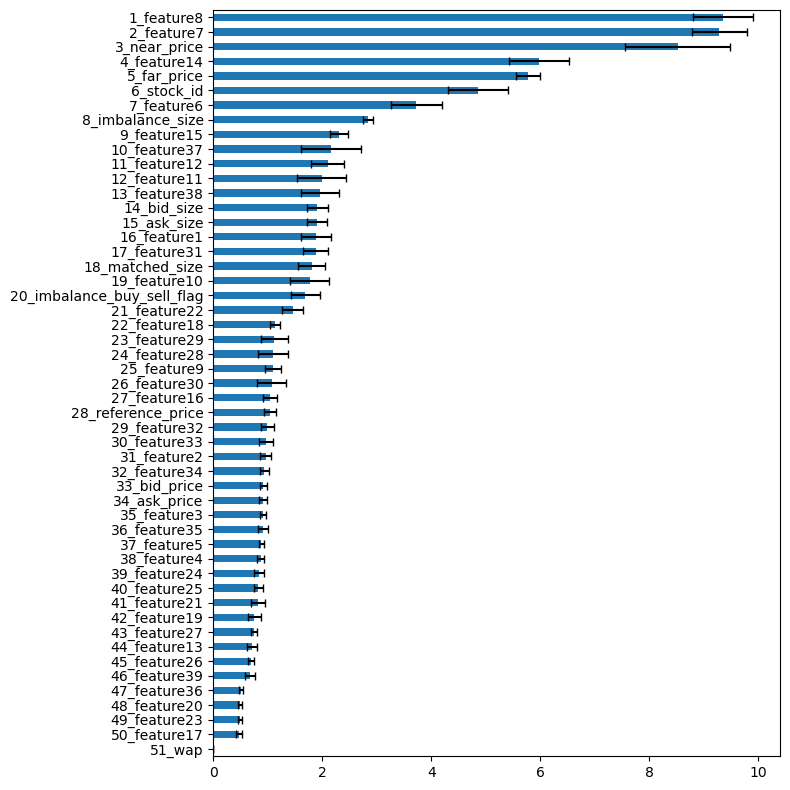

Index(['51_wap', '50_feature17', '49_feature23', '48_feature20',
       '47_feature36', '46_feature39', '45_feature26', '44_feature13',
       '43_feature27', '42_feature19'],
      dtype='object')

In [9]:
display(result_pred)
display(result_true)
print(fimps.shape)
display(fimps.tail(50))

_, ax = plt.subplots(figsize=(8, 8))
fimps['mean_fimps'].plot(kind='barh', xerr=fimps['std_fimps'], capsize=3, ax=ax)  
plt.tight_layout()
plt.show()

fimps_quantile_th = fimps['mean_fimps'].quantile(q=0.2)
display(fimps.query('mean_fimps < @fimps_quantile_th').index)

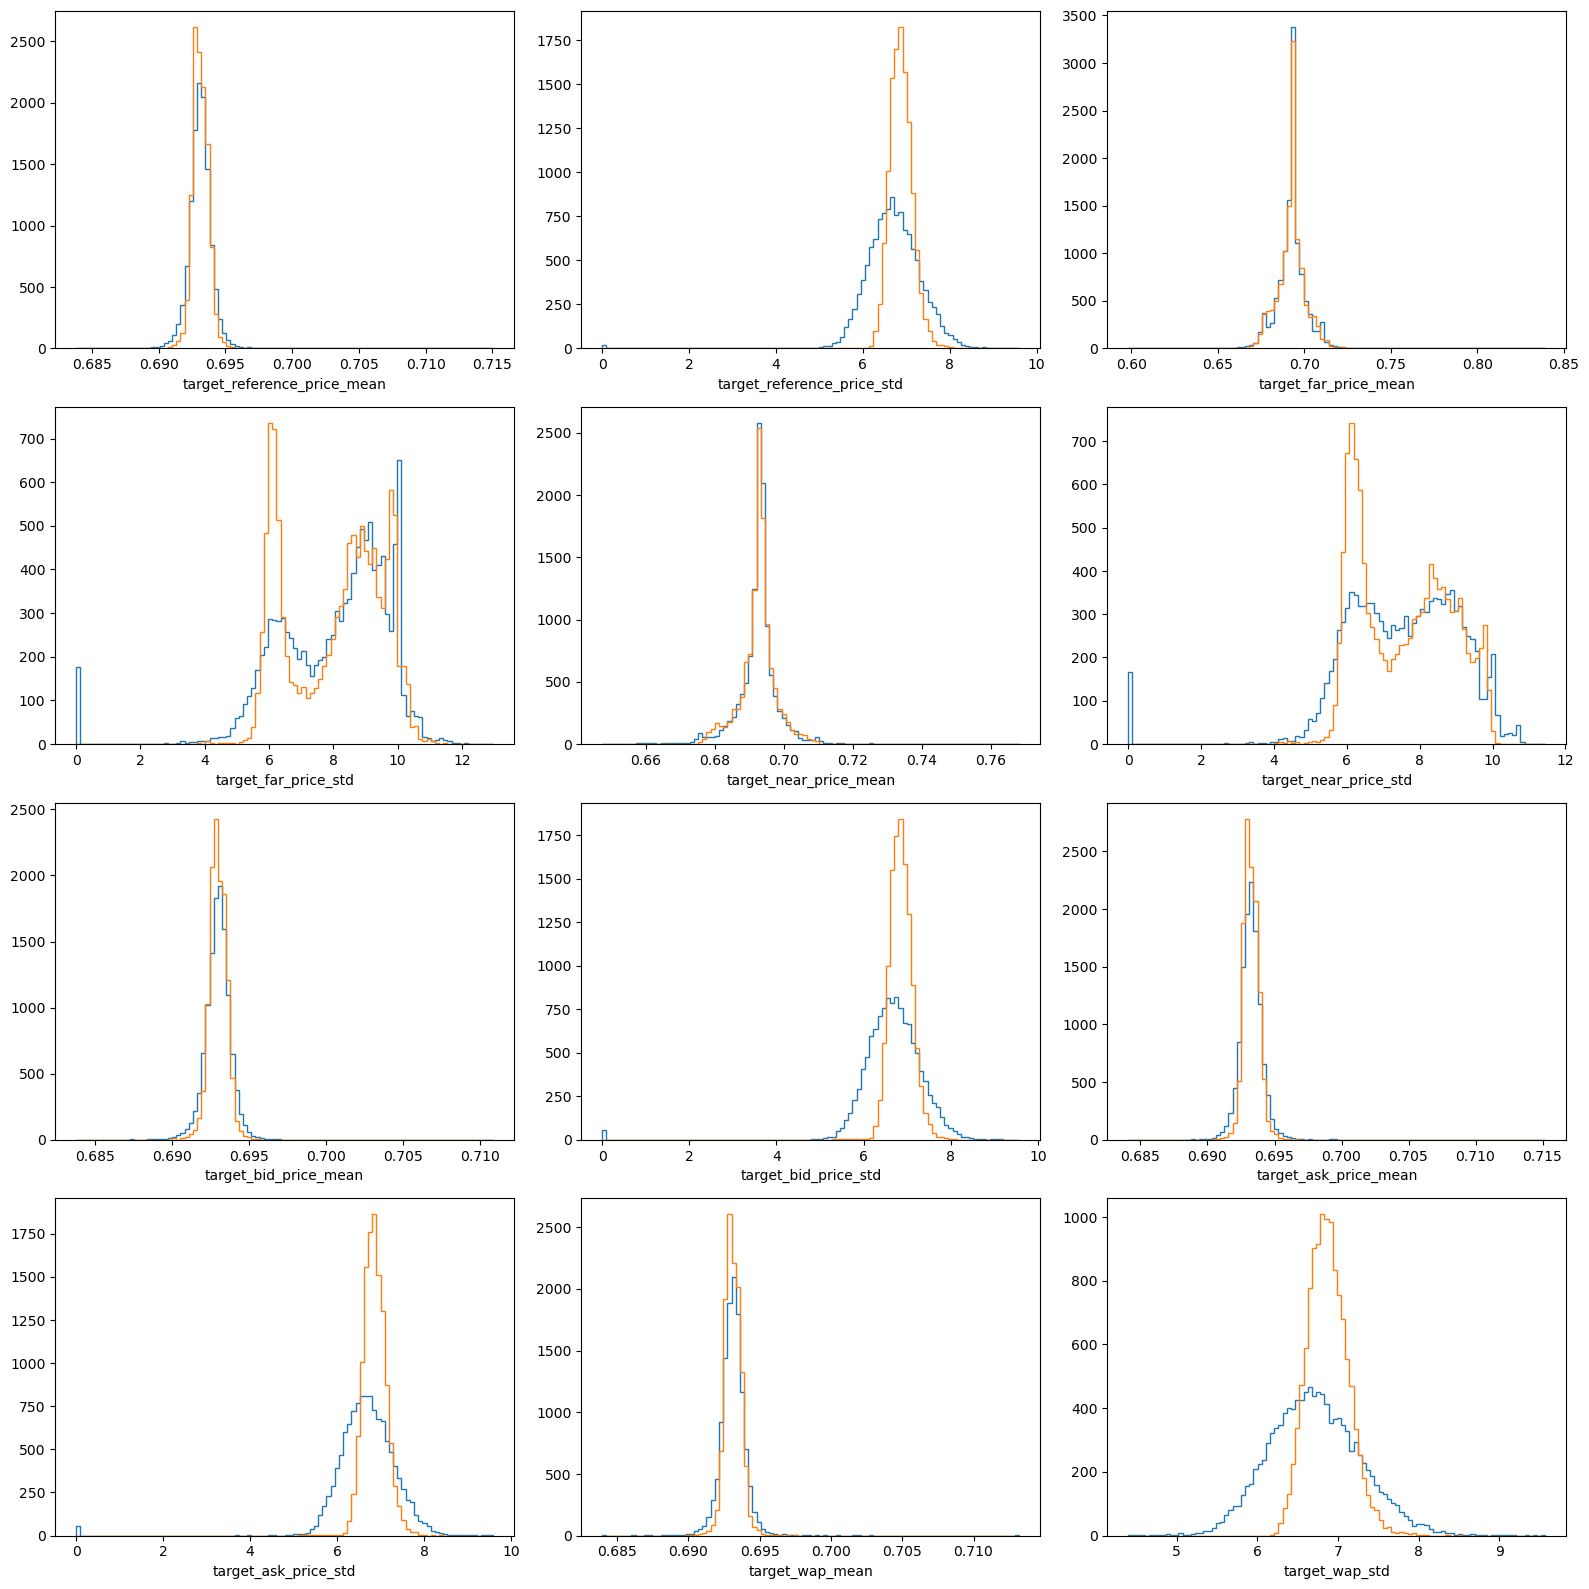

In [10]:
target_columns = [col for col in train_df.columns if 'target' in col]
num_targets = len(target_columns)
nrows = num_targets // 3 if num_targets % 3 == 0 else num_targets // 3 + 1

_, axs = plt.subplots(nrows, 3, figsize=(16, 16))
for i in range(num_targets):
    _, bins, _ = axs[i//3, i%3].hist(result_true[:, i], bins=100, histtype='step')
    axs[i//3, i%3].hist(result_pred[:, i], bins=bins, histtype='step')
    axs[i//3, i%3].set_xlabel(target_columns[i])
plt.tight_layout()
plt.show()

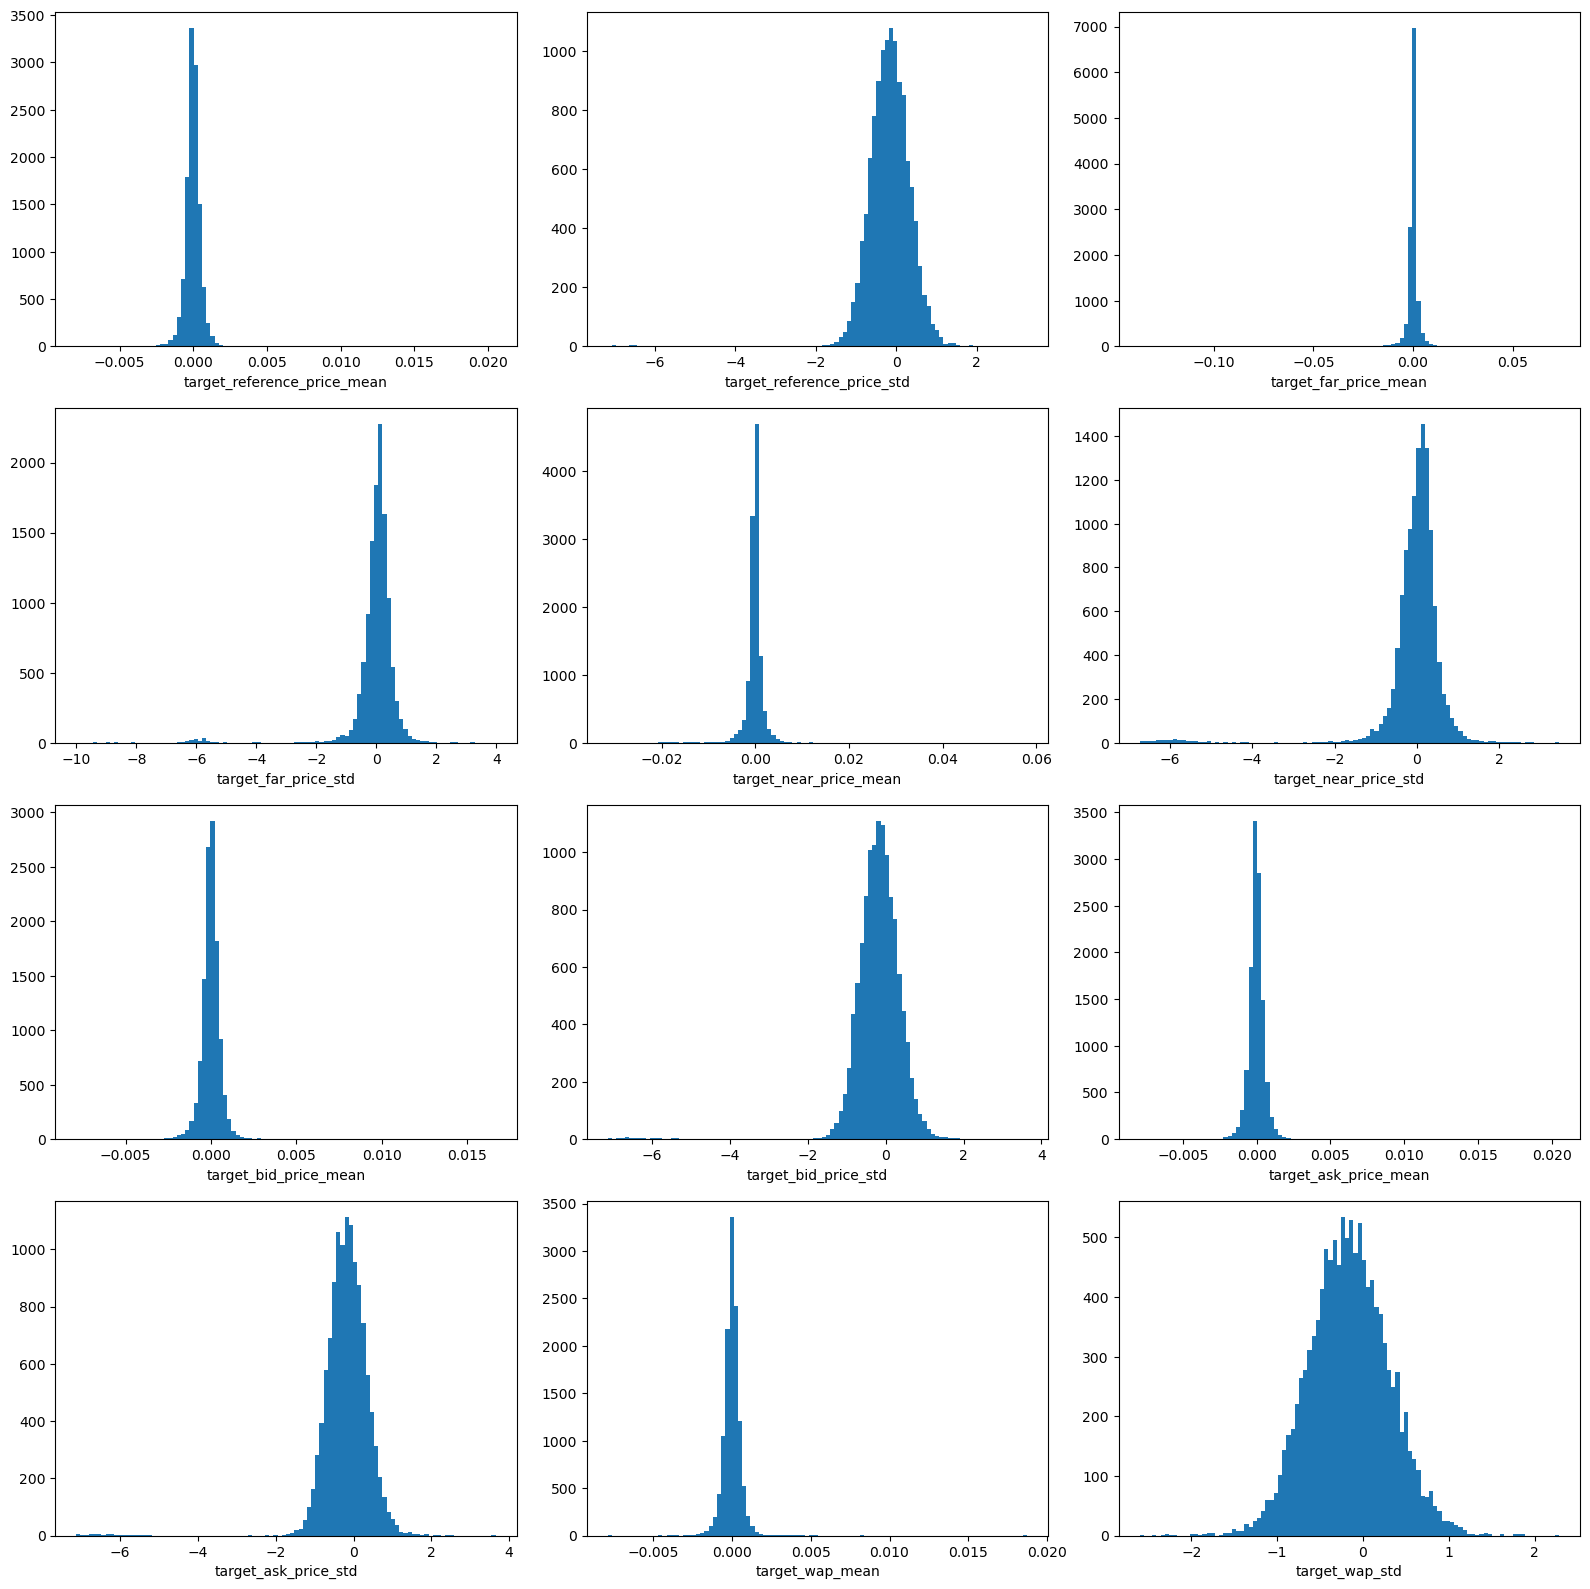

In [11]:
target_columns = [col for col in train_df.columns if 'target' in col]
num_targets = len(target_columns)
nrows = num_targets // 3 if num_targets % 3 == 0 else num_targets // 3 + 1

_, axs = plt.subplots(nrows, 3, figsize=(16, 16))
for i in range(num_targets):
    axs[i//3, i%3].hist(result_true[:, i]-result_pred[:, i], bins=100)
    axs[i//3, i%3].set_xlabel(target_columns[i])
plt.tight_layout()
plt.show()

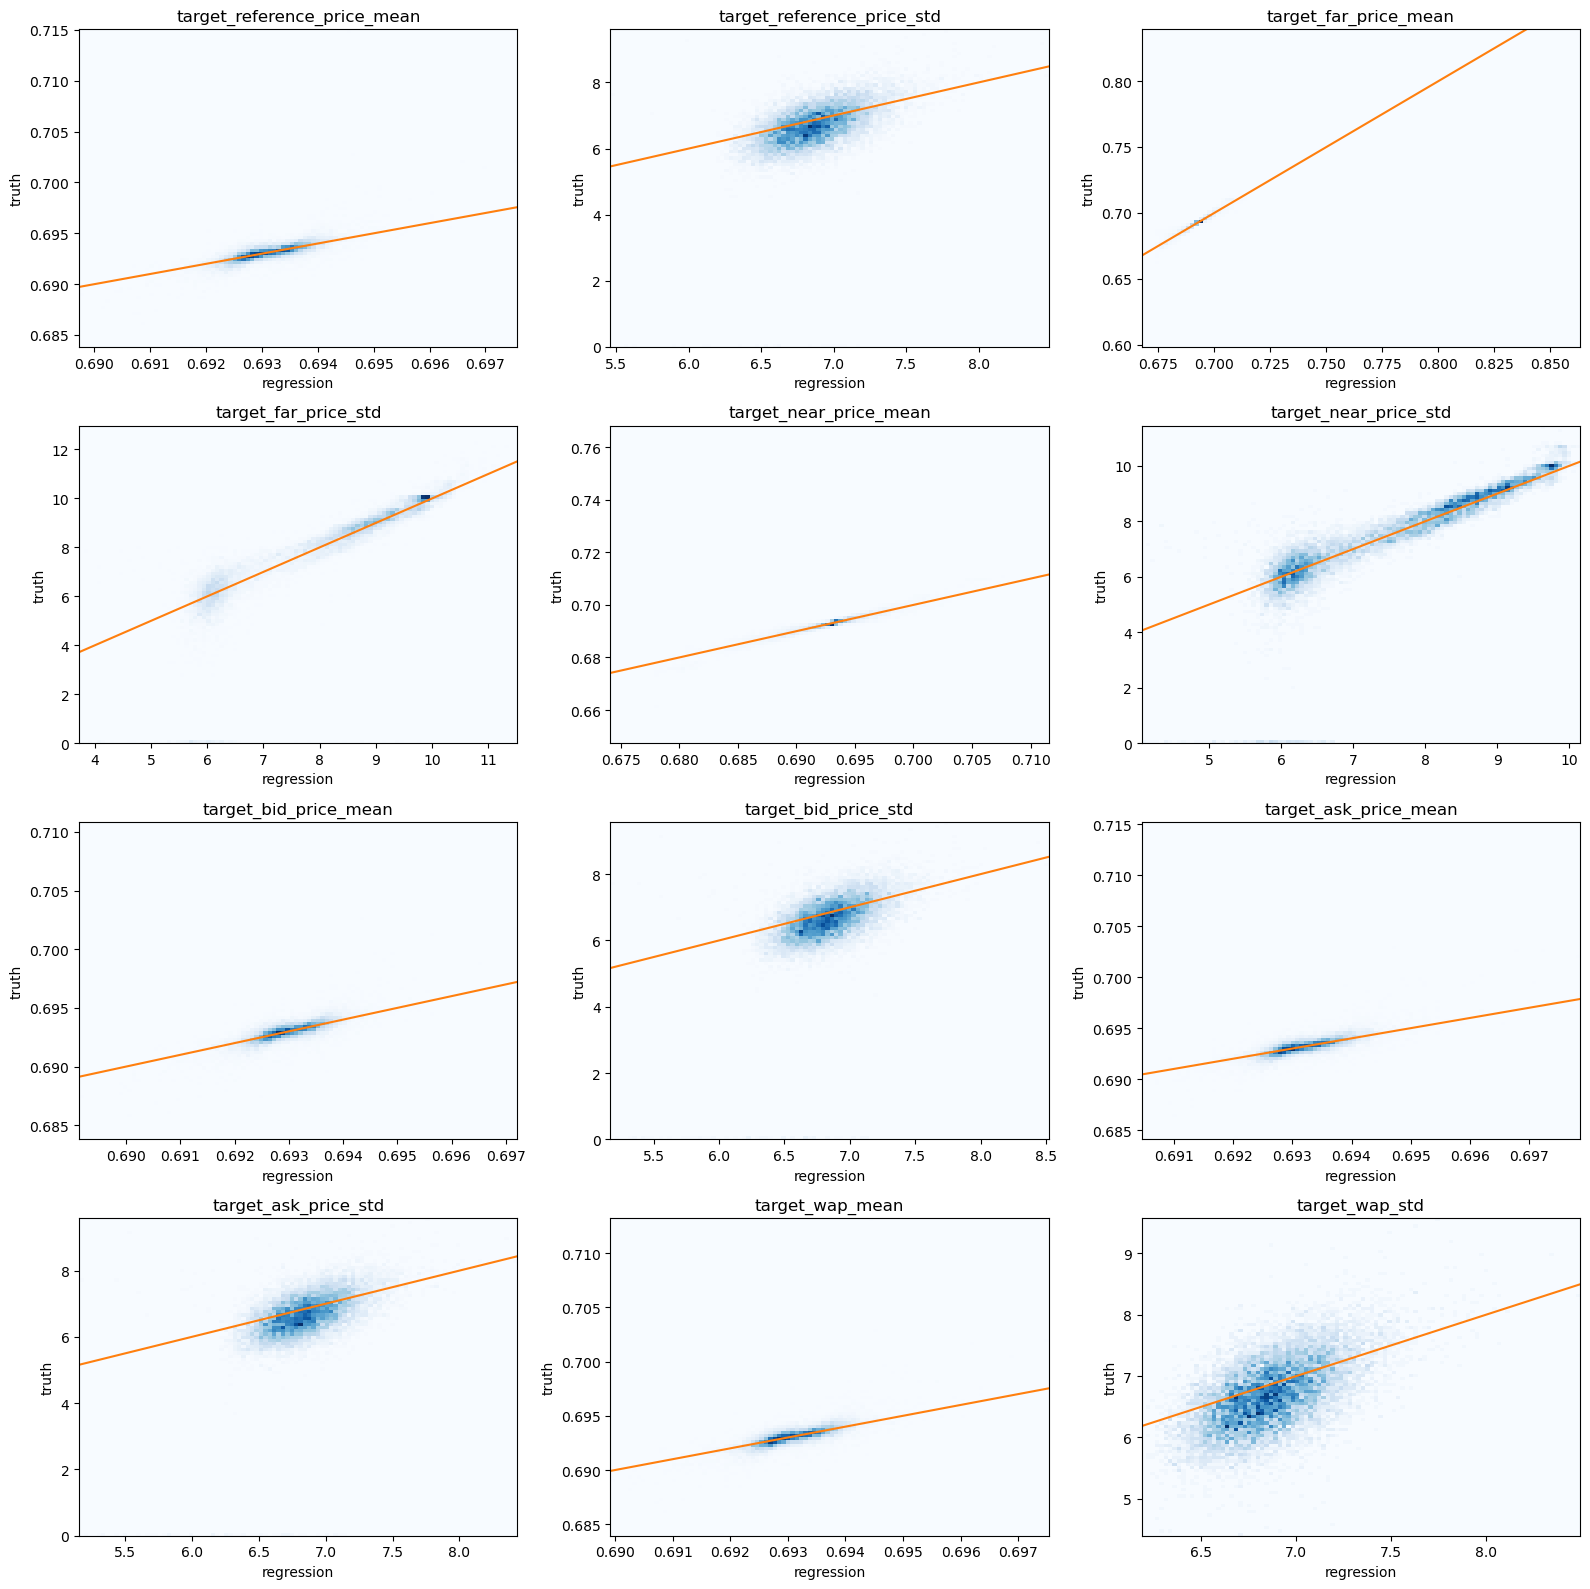

In [12]:
arget_columns = [col for col in train_df.columns if 'target' in col]
num_targets = len(target_columns)
nrows = num_targets // 3 if num_targets % 3 == 0 else num_targets // 3 + 1

_, axs = plt.subplots(nrows, 3, figsize=(16, 16))
for i in range(num_targets):
    axs[i//3, i%3].hist2d(result_pred[:, i], result_true[:, i], bins=100, cmap='Blues')
    axs[i//3, i%3].plot([-100, 100], [-100, 100], color='tab:orange')
    axs[i//3, i%3].set_xlabel('regression')
    axs[i//3, i%3].set_ylabel('truth')
    axs[i//3, i%3].set_title(target_columns[i])
plt.tight_layout()
plt.show()

In [13]:
target_columns = [col for col in train_df.columns if 'target' in col]
num_targets = len(target_columns)

for i in range(num_targets):
   r = np.corrcoef(result_true[:, i], result_pred[:, i])
   print(f'{target_columns[i]}: {r[0, 1]:.4f}')

target_reference_price_mean: 0.7778
target_reference_price_std: 0.5511
target_far_price_mean: 0.8609
target_far_price_std: 0.8814
target_near_price_mean: 0.9409
target_near_price_std: 0.8708
target_bid_price_mean: 0.7713
target_bid_price_std: 0.5212
target_ask_price_mean: 0.7684
target_ask_price_std: 0.5249
target_wap_mean: 0.7658
target_wap_std: 0.5824


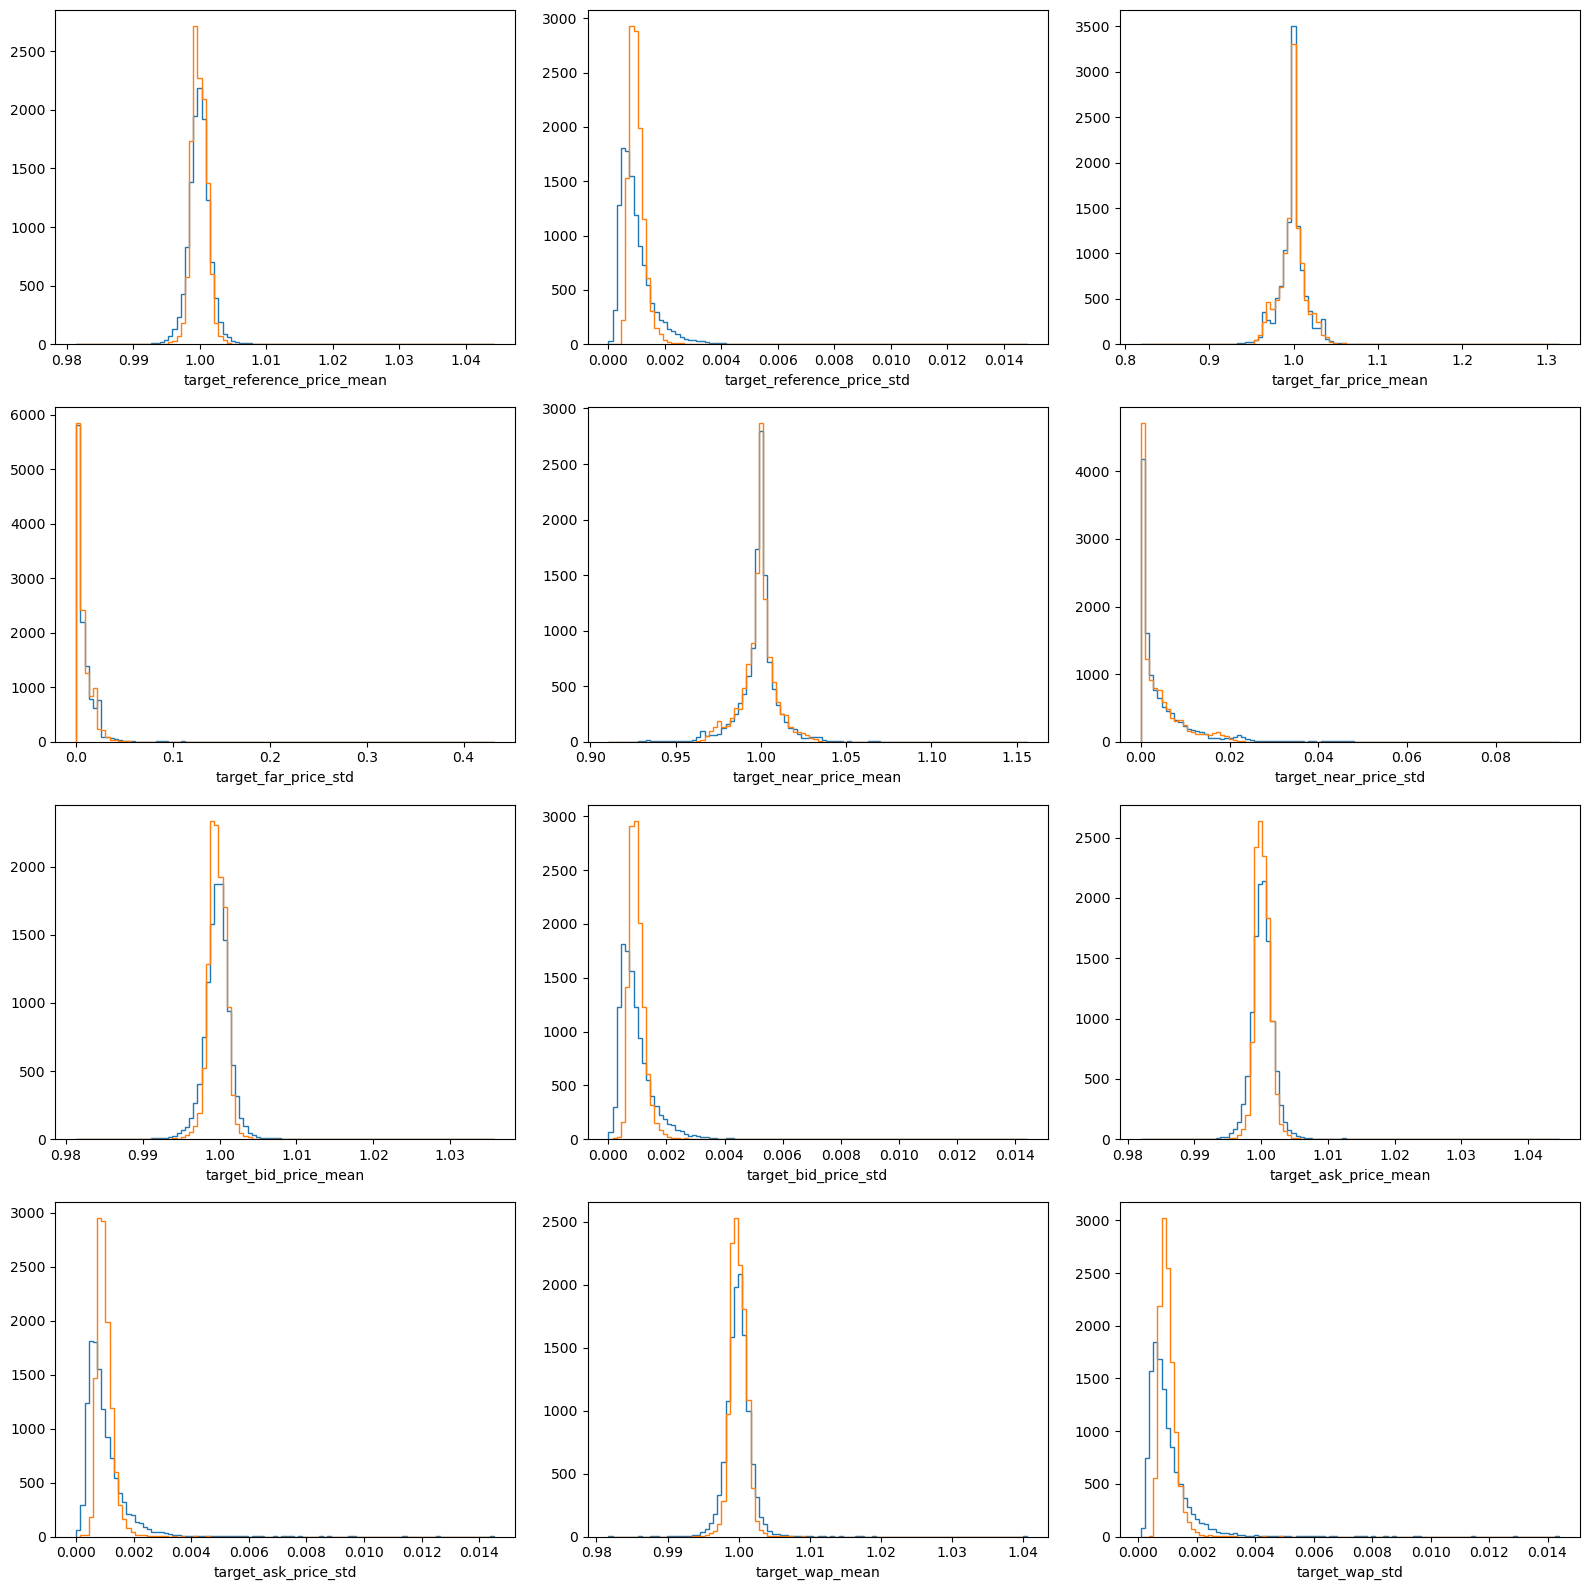

In [14]:
target_columns = [col for col in train_df.columns if 'target' in col]
num_targets = len(target_columns)
nrows = num_targets // 3 if num_targets % 3 == 0 else num_targets // 3 + 1

_, axs = plt.subplots(nrows, 3, figsize=(16, 16))
for i in range(num_targets):
    true = np.exp(result_true[:, i]) - 1
    reg = np.exp(result_pred[:, i]) - 1
    if 'std' in target_columns[i]:
        true /= 1e+06
        reg /= 1e+06
    _, bins, _ = axs[i//3, i%3].hist(true, bins=100, histtype='step')
    axs[i//3, i%3].hist(reg, bins=bins, histtype='step')
    axs[i//3, i%3].set_xlabel(target_columns[i])
plt.tight_layout()
plt.show()

## train catboost model using all data

In [16]:
target_columns = [col for col in train_df.columns if 'target' in col]
print(target_columns)
feature_columns = [col for col in train_df.columns if col not in target_columns and col != 'date_id']


train_pool = Pool(
    data=train_df[feature_columns],
    label=train_df[target_columns],
)

params['iterations'] = mean_num_iteration

model = CatBoostRegressor(**params)
model.fit(
    X=train_pool,
    use_best_model=True,
    verbose=500,
)
model.save_model(
    outputs_dir_path.joinpath(f'catboost_trained_using_alldata_predict_price_statistics.txt'),
)

['target_reference_price_mean', 'target_reference_price_std', 'target_far_price_mean', 'target_far_price_std', 'target_near_price_mean', 'target_near_price_std', 'target_bid_price_mean', 'target_bid_price_std', 'target_ask_price_mean', 'target_ask_price_std', 'target_wap_mean', 'target_wap_std']


You should provide test set for use best model. use_best_model parameter has been switched to false value.


0:	learn: 2.5407223	total: 218ms	remaining: 18m
500:	learn: 1.5103600	total: 1m 56s	remaining: 17m 16s
1000:	learn: 1.4298298	total: 3m 53s	remaining: 15m 22s
1500:	learn: 1.3848905	total: 5m 51s	remaining: 13m 27s
2000:	learn: 1.3497680	total: 7m 48s	remaining: 11m 31s
2500:	learn: 1.3208987	total: 9m 45s	remaining: 9m 34s
3000:	learn: 1.2950692	total: 11m 42s	remaining: 7m 36s
3500:	learn: 1.2722115	total: 13m 38s	remaining: 5m 39s
4000:	learn: 1.2523019	total: 15m 35s	remaining: 3m 42s
4500:	learn: 1.2343214	total: 17m 32s	remaining: 1m 45s
4951:	learn: 1.2193126	total: 19m 18s	remaining: 0us
